<a href="https://colab.research.google.com/github/skauntey/movie-sentiment-analysis/blob/ALMS/Sentimental_analysis_v.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!echo '{"username":"kaunteyshah","key":"e2678a9d0e44e057000b9daf059111b5"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os, shutil
import kaggle

#### 1. Downloading Kaggle files

In [ ]:
file = 'dataset/'
for files in os.listdir(file):
    path = os.path.join(os.getcwd()+'/'+'dataset/',files)
    try:
        shutil.rmtree(path)
    except:
      raise

In [ ]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('sentiment-analysis-on-movie-reviews', path= str(os.getcwd())+"/dataset/", force = True)

#### 2. Unzipping Kaggle files

In [ ]:
import zipfile
ziped_file = r'dataset/sentiment-analysis-on-movie-reviews.zip'
with zipfile.ZipFile(ziped_file) as zip_file:
    for member in zip_file.namelist():
        if member.split('.')[-1] == "zip":
            fdir = member.split('.')[0]
            zip_file.extract(member, path= os.path.join('dataset/'+fdir))
            # extracting individual train and test files in their respective folders
            zippedfile_name = os.listdir(os.path.join(str(os.getcwd()+'/dataset/'+fdir+'/')))
            zippedfile = os.path.join(str(os.getcwd())+'/dataset/'+ fdir, zippedfile_name[0])
            with zipfile.ZipFile(zippedfile, mode='r') as tsv_zip:
                tsv_zip.extractall(path = os.path.join('dataset/'+fdir+'/'))
                
            os.remove(zippedfile)
        else:
            continue
            
os.remove(ziped_file)


#### 3. Testing files

In [ ]:
tsvfile = 'dataset/train/train.tsv'
# read the data
tsv_read = pd.read_csv(tsvfile, sep="\t")
pdf = pd.DataFrame(tsv_read, columns=['Phrase', 'Sentiment'], index= None)
print (set(pdf['Sentiment']))

{0, 1, 2, 3, 4}


In [ ]:
train_split = 0.8
val_split = 0.2
test_split = 0

training_mark = int(abs(len(pdf) * train_split))
# validation_mark = np.add(training_mark, int(abs(len(pdf)) * val_split))

print(training_mark)
print(validation_mark)

training_set = np.array(pdf.loc[1:training_mark])
validation_set = np.array(pdf.loc[training_mark:]) # pdf.loc[training_mark:validation_mark]
# test_set = np.array(pdf.loc[validation_mark:])

print(training_set.shape)
print(validation_set.shape)
print(test_set.shape)


124848
156060
(124848, 2)
(31212, 2)
(0, 2)


In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

import time

def data_distribution_standardisation(DataFrame):
    phrases = [DataFrame[:,0][x].lower() for x in range(len(DataFrame))]
    sentiments = np.array([DataFrame[:,1][y] for y in range(len(DataFrame))])
    
    for word in stopwords:
        token = " "+ word +" "
        phrases = [phrases[i].replace(token, " ") for i in range(len(phrases))]

    return phrases, sentiments

train_ds, train_labels = data_distribution_standardisation(training_set)
t0 = time.process_time()
val_ds, val_labels = data_distribution_standardisation(validation_set)
t1 = time.process_time()
print('time taken: {}'.format(t1 - t0))
print(type(train_ds), type(train_labels))
print(type(train_labels[0]))
print(len(train_labels))
print(train_labels[:10])

time taken: 1.048165243000767
<class 'list'> <class 'numpy.ndarray'>
<class 'numpy.int64'>
124848
[2 2 2 2 2 2 2 2 2 2]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:

def tokenizing_dataset(dataset):
    tokenizer = Tokenizer(num_words = 10000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token= '<00V>')
    tokenizer.fit_on_texts(dataset)
    word_index = tokenizer.word_index
    if len(word_index)>= 10000:
        print ('There are more than 10,000 tokens! This may take longer to compute!')
    
    # Now I have tokenized sentences using text_to_sequences and therafter padded to make them all at the same length
    sequences = tokenizer.texts_to_sequences(dataset)
    padded_sentences = pad_sequences(sequences, maxlen=30, truncating ='post', padding='post')
    
    return padded_sentences, word_index, sequences

padded_train, train_word_index, train_sequence = tokenizing_dataset(train_ds)
padded_val, val_word_index, val_sequence = tokenizing_dataset(val_ds)
padded_test, test_word_index, test_sequence = tokenizing_dataset(test_ds)

print (padded_train[0], len(train_word_index), type(train_sequence))
print (padded_val[0], len(val_word_index), val_sequence[0])
print (type(padded_train))
print(train_sequence[0:10])
print(len(padded_train[0]))
print(len(padded_val[0]))


There are more than 10,000 tokens! This may take longer to compute!
[   4  268    1 5316 5841   19 2460    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] 13605 <class 'list'>
[ 720    2   70 5838  363    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] 6825 [720, 2, 70, 5838, 363]
<class 'numpy.ndarray'>
[[4, 268, 1, 5316, 5841, 19, 2460], [4, 268], [4], [268], [8, 1, 5316, 5841, 19, 2460], [8], [1, 5316, 5841, 19, 2460], [1], [5316, 5841, 19, 2460], [5316, 5841]]
30
30


In [ ]:
matching = 0
non_matching = 0
for key in val_word_index.keys():
    if key in train_word_index.keys():
        matching += 1
    else:
        non_matching +=1
        
print (matching, non_matching)

5141 1684


In [ ]:
type(train_sequence)

list

In [ ]:
def decoding_sequences(word_index, sequences):
    reversed_index = dict(map(reversed, word_index.items()))
    for letter in range(len(sequences)):
        reversed_index.get(letter) 
    reversed_sequence = [reversed_index.get(letter) for letter in sequences]
    return (' '.join(reversed_sequence))
    
print(decoding_sequences(train_word_index, train_sequence[0]))
print(train_ds[0])

a series <00V> demonstrating adage good goose
a series escapades demonstrating adage good goose


In [ ]:
len(train_word_index)

13605

In [ ]:
vocabulary_size = 10000 #len(padded_train)
embedding_dim = 16
max_length = 30
trunc_type = 'post'
oov_tok = '<00V>'

model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocabulary_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(5, activation ='sigmoid')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics= ['accuracy'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 30, 16)            160000    
_________________________________________________________________
flatten_26 (Flatten)         (None, 480)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 24)                11544     
_________________________________________________________________
dense_62 (Dense)             (None, 5)                 125       
Total params: 171,669
Trainable params: 171,669
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(padded_train, train_labels, epochs = num_epochs, validation_data = (padded_val, val_labels))

Epoch 1/30
3902/3902 [==============================] - 17s 4ms/step - loss: 1.1184 - accuracy: 0.5593 - val_loss: 1.6146 - val_accuracy: 0.4308
Epoch 2/30
3902/3902 [==============================] - 16s 4ms/step - loss: 0.7905 - accuracy: 0.6809 - val_loss: 1.8210 - val_accuracy: 0.4263
Epoch 3/30
3902/3902 [==============================] - 16s 4ms/step - loss: 0.6957 - accuracy: 0.7197 - val_loss: 1.9164 - val_accuracy: 0.4075
Epoch 4/30
3902/3902 [==============================] - 16s 4ms/step - loss: 0.6276 - accuracy: 0.7472 - val_loss: 2.1064 - val_accuracy: 0.4088
Epoch 5/30
3902/3902 [==============================] - 16s 4ms/step - loss: 0.5841 - accuracy: 0.7653 - val_loss: 2.1886 - val_accuracy: 0.3958
Epoch 6/30
3902/3902 [==============================] - 16s 4ms/step - loss: 0.5477 - accuracy: 0.7808 - val_loss: 2.3273 - val_accuracy: 0.3973
Epoch 7/30
3902/3902 [==============================] - 16s 4ms/step - loss: 0.5222 - accuracy: 0.7912 - val_loss: 2.4393 - val_ac

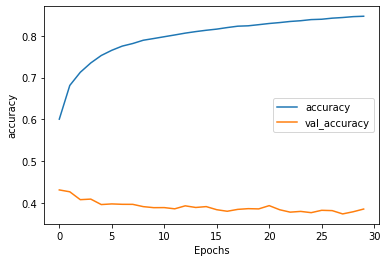

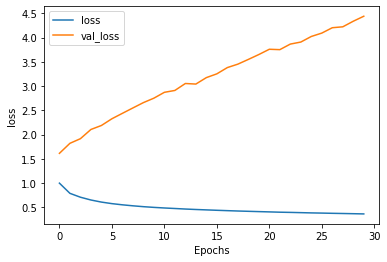

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")